# GoodReads Poetry Ratings Tutorial #

This notebook will guide you through the process of utilizing a publically available dataset  on GoodReads.com of poetry ratings and using shaped to build a ranking model. The steps taken in this tutorial are as follows:

- Loading the dataset and some basic Exploratory Data Analysis
- Preprocessing for the Shaped API to properly ingest
- Setting up an initial Shaped model
- Model Enrichment using item features
- Generating Poetry recommendations for a power user

Let's get started!

## Data Preperation ##

### Notebook Setup ###

For this tutorial, we require the following python packages to be used:

In [72]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import pandoc

Replace ```<YOUR_API_KEY>``` with your own API key in the line of code below:

In [2]:
SHAPED_API_KEY = os.getenv('TEST_SHAPED_API_KEY', 'id6xF0pH5v3qzUsNrbKPJ7GwokJJETBu6PqYh7hS')

Install Shaped & Pyyaml for model schema creation if you have not already:

In [ ]:
!pip install shaped
!pip install pyyaml

In [3]:
! shaped init --api-key $SHAPED_API_KEY 

Initializing with config: {'api_key': 'id6xF0pH5v3qzUsNrbKPJ7GwokJJETBu6PqYh7hS', 'env': 'prod'}


### Dataset Download ###

Firstly, we our going to download our publically available data by using CLI commands,then unzip and read into json files we can interact with:

In [4]:
DIR_NAME = "notebook_assets"
! mkdir $DIR_NAME

mkdir: notebook_assets: File exists


In [ ]:
! echo "Downloading GoodReads Poetry data..."

## Poetry Books Data ##
! wget https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/goodreads/byGenre/goodreads_books_poetry.json.gz --no-check-certificate -P $DIR_NAME
! gzip -d $DIR_NAME/goodreads_books_poetry.json.gz

## Poetry Interactions Data ##
! wget https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/goodreads/byGenre/goodreads_interactions_poetry.json.gz --no-check-certificate -P $DIR_NAME
! gzip -d $DIR_NAME/goodreads_interactions_poetry.json.gz

## Poetry Books Data ##
! wget https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/goodreads/byGenre/goodreads_reviews_poetry.json.gz --no-check-certificate -P $DIR_NAME
! gzip -d $DIR_NAME/goodreads_reviews_poetry.json.gz

In [5]:
data_dir = "notebook_assets"

events_df = pd.read_json(f'{data_dir}/goodreads_interactions_poetry.json', lines=True)
users_df = pd.read_json(f'{data_dir}/goodreads_reviews_poetry.json', lines=True)
items_df = pd.read_json(f'{data_dir}/goodreads_books_poetry.json', lines=True)

In [6]:
display(events_df.head())
display(users_df.head())
display(items_df.head())

,user_id,book_id,review_id,is_read,rating,review_text_incomplete,date_added,date_updated,read_at,started_at
0,8842281e1d1347389f2ab93d60773d4d,1384,1bad0122cebb4aa9213f9fe1aa281f66,True,4,,Wed May 09 09:33:44 -0700 2007,Wed May 09 09:33:44 -0700 2007,,
1,8842281e1d1347389f2ab93d60773d4d,1376,eb6e502d0c04d57b43a5a02c21b64ab4,True,4,,Wed May 09 09:33:18 -0700 2007,Wed May 09 09:33:18 -0700 2007,,
2,8842281e1d1347389f2ab93d60773d4d,30119,787564bef16cb1f43e0f641ab59d25b7,True,5,,Sat Jan 13 13:44:20 -0800 2007,Wed Mar 22 11:45:08 -0700 2017,Tue Mar 01 00:00:00 -0800 1983,
3,72fb0d0087d28c832f15776b0d936598,24769928,8c80ee74743d4b3b123dd1a2e0c0bcac,False,0,,Wed Apr 27 11:05:51 -0700 2016,Wed Apr 27 11:05:52 -0700 2016,,
4,72fb0d0087d28c832f15776b0d936598,30119,2a83589fb597309934ec9b1db5876aaf,True,3,,Mon Jun 04 18:58:08 -0700 2012,Mon Jun 04 18:58:13 -0700 2012,,


,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,3ca7375dba942a760e53b726c472a7dd,402128,28423ff309bc896c071a8d9df4a10e8a,5,I have three younger siblings and we grew up w...,Tue Jun 12 08:59:04 -0700 2012,Fri Jun 15 11:41:12 -0700 2012,,,0,0
1,0ef32090550901ead25cb0ea21c4d36b,92270,2db1180992e2b0b1631a3ac5644bde84,5,This is my favorite collection of poetry.,Mon Apr 14 18:42:40 -0700 2014,Mon Apr 14 18:43:05 -0700 2014,Wed Jan 01 00:00:00 -0800 1997,,0,0
2,0ef32090550901ead25cb0ea21c4d36b,908708,bca57fa40e92c9261b00b03dbebd96fe,4,"He's so disturbing. So very, very disturbing.",Tue Apr 22 13:58:10 -0700 2008,Tue Apr 22 13:58:33 -0700 2008,,,0,0
3,d37b46b2190ed7c518259f29b47a9b36,253264,cb1ebc02d8b2aff15735d513877463ce,5,I just reread this play for a class I am takin...,Wed Sep 27 19:08:08 -0700 2017,Sat Sep 30 06:39:45 -0700 2017,Wed Sep 27 00:00:00 -0700 2017,Tue Sep 26 00:00:00 -0700 2017,1,0
4,af157d0205b8a901dee6d4a2aed7e6ad,70885,8dca128b8e869048a7442c18659dbece,5,"Cuanto mas leo, mas me gusta. Su poesia es env...",Thu Jun 18 20:00:03 -0700 2015,Thu Jun 18 20:01:29 -0700 2015,Thu Jun 18 00:00:00 -0700 2015,Tue Jun 16 00:00:00 -0700 2015,0,0


,isbn,text_reviews_count,series,country_code,language_code,popular_shelves,asin,is_ebook,average_rating,kindle_asin,...,publication_month,edition_information,publication_year,url,image_url,book_id,ratings_count,work_id,title,title_without_series
0,,1,[],US,eng,"[{'count': '8', 'name': 'to-read'}, {'count': ...",,false,3.83,,...,11,,1887,https://www.goodreads.com/book/show/16037549-v...,https://images.gr-assets.com/books/1348176637m...,16037549,3,5212748,Vision of Sir Launfal and Other Poems,Vision of Sir Launfal and Other Poems
1,0811223981,2,[],US,,"[{'count': '100', 'name': 'to-read'}, {'count'...",,false,3.83,B00U2WY9U8,...,4,,2015,https://www.goodreads.com/book/show/22466716-f...,https://images.gr-assets.com/books/1404958407m...,22466716,37,41905435,Fairy Tales: Dramolettes,Fairy Tales: Dramolettes
2,0374428115,7,[],US,,"[{'count': '32', 'name': 'to-read'}, {'count':...",,false,4.38,,...,7,,2008,https://www.goodreads.com/book/show/926662.Gro...,https://s.gr-assets.com/assets/nophoto/book/11...,926662,45,911665,Growltiger's Last Stand and Other Poems,Growltiger's Last Stand and Other Poems
3,0156182890,12,[],US,,"[{'count': '554', 'name': 'to-read'}, {'count'...",,false,3.71,B00IWTRB1W,...,3,,1964,https://www.goodreads.com/book/show/926667.The...,https://images.gr-assets.com/books/1382939971m...,926667,115,995066,The Cocktail Party,The Cocktail Party
4,1942004192,4,[],US,eng,"[{'count': '228', 'name': 'to-read'}, {'count'...",,false,5.00,,...,12,First,2015,https://www.goodreads.com/book/show/29065952-l...,https://images.gr-assets.com/books/1455198396m...,29065952,9,49294781,Louder Than Everything You Love,Louder Than Everything You Love


Taking a look at the downloaded files, we can see that we have three Pandas DataFrames of interest. They are:

- ```events_df``` : DataFrame stored in ```goodreads_interactions_poetry.json```. Contains data detailing the individual ratings of the poetry books by a given user.
- ```users_df``` : DataFrame stored in ```goodreads_reviews_poetry.json```. Contains information on all reviews on individual books by individual users on GoodReads.
- ```items_df``` : DataFrame stored in ```goodreads_books_poetry.json```. Contains basic information on different poetry books, including their average rating on GoodReads.

We have quite a bit of data here. However, for our initial basic Shaped model to get up and running, we only require a few different collumns from these dataframes. Shaped requires that we feed it at least:

 - ```user_id```, ```item_id```, ```label``` & ```created_at``` Collumns for the Events Data
 - ```user_id``` Collumn for the Users Data
 - ```item_id``` Collumn for the Item Data

Let's take a look at the collumns within these DataFrames:

In [7]:
print("Events DataFrame Columns = {}".format(events_df.columns.values))
print("Users DataFrame Columns = {}".format(users_df.columns.values))
print("Items DataFrame Columns = {}".format(items_df.columns.values))

Events DataFrame Columns = ['user_id' 'book_id' 'review_id' 'is_read' 'rating'
 'review_text_incomplete' 'date_added' 'date_updated' 'read_at'
 'started_at']
Users DataFrame Columns = ['user_id' 'book_id' 'review_id' 'rating' 'review_text' 'date_added'
 'date_updated' 'read_at' 'started_at' 'n_votes' 'n_comments']
Items DataFrame Columns = ['isbn' 'text_reviews_count' 'series' 'country_code' 'language_code'
 'popular_shelves' 'asin' 'is_ebook' 'average_rating' 'kindle_asin'
 'similar_books' 'description' 'format' 'link' 'authors' 'publisher'
 'num_pages' 'publication_day' 'isbn13' 'publication_month'
 'edition_information' 'publication_year' 'url' 'image_url' 'book_id'
 'ratings_count' 'work_id' 'title' 'title_without_series']


By looking at the collumns above, we can see that we have the neccasary data to start working with Shaped. Our ```book_id``` collumn will serve as our item id's, our ```rating``` collumn will be our label feature and our ```date_added``` collumns will be our timestamps. Let's keep these collumns aswell as a few more features that may be useful down the road:

In [8]:
events_df = events_df[["user_id","book_id","review_id","is_read","rating","date_added"]]
users_df = users_df[["user_id","book_id","review_id","rating","review_text","date_added","n_votes"]]
items_df = items_df[["book_id","title","language_code","authors","description","publication_year","num_pages","average_rating"]]

## DataFrame Cleaning ##

Let's do some tidying up of these DataFrames! Firstly, we want to check for any missing values and duplicate rows, and sort those out accordingly. We will then have a look at the datatypes of each relevant collumn, and then have a look at the distribution of the ratings to see what we might be able to expect from our Shaped rating model. Additionally, we will randomly sample 100,000 rows from the ```events_df``` and ```users_df``` to keeps things simple:

### Events DataFrame ###

user_id       0
book_id       0
review_id     0
is_read       0
rating        0
date_added    0
dtype: int64

Number of Duplicated Rows = 0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 549257 to 1556479
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   user_id     100000 non-null  object
 1   book_id     100000 non-null  int64 
 2   review_id   100000 non-null  object
 3   is_read     100000 non-null  bool  
 4   rating      100000 non-null  int64 
 5   date_added  100000 non-null  object
dtypes: bool(1), int64(2), object(3)
memory usage: 4.7+ MB
            book_id         rating
count  1.000000e+05  100000.000000
mean   4.965551e+06       3.800960
std    8.407869e+06       1.371795
min    2.340000e+02       0.000000
25%    3.011800e+04       3.000000
50%    2.939240e+05       4.000000
75%    6.667403e+06       5.000000
max    3.629540e+07       5.000000
Cleaned Events DataFrame Dimensions = (100000, 6)


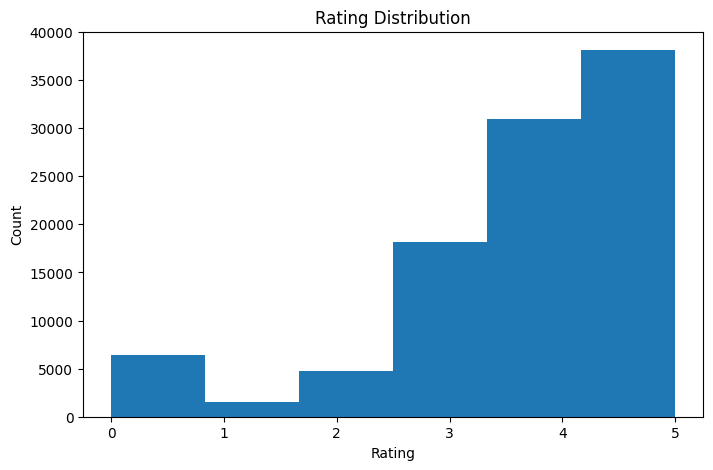

In [66]:
display(events_df.isnull().sum()) 
print("Number of Duplicated Rows = {}".format(events_df.duplicated().sum()))
events_df = events_df[events_df['is_read'] == 1]
events_df = events_df.sample(n=100000)
events_df.info()
print(events_df.describe())
print("Cleaned Events DataFrame Dimensions = {}".format(events_df.shape))
plt.subplots(figsize=(8,5))
plt.hist(events_df['rating'],bins=6)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Rating Distribution')
plt.show()

### Users DataFrame ###

user_id        0
book_id        0
review_id      0
rating         0
review_text    0
date_added     0
n_votes        0
dtype: int64

Number of Duplicated Rows = 0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 10057 to 3981
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   user_id      100000 non-null  object
 1   book_id      100000 non-null  int64 
 2   review_id    100000 non-null  object
 3   rating       100000 non-null  int64 
 4   review_text  100000 non-null  object
 5   date_added   100000 non-null  object
 6   n_votes      100000 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 6.1+ MB
            book_id         rating       n_votes
count  1.000000e+05  100000.000000  100000.00000
mean   1.025060e+07       3.815050       1.53300
std    1.028196e+07       1.313362       7.77355
min    2.340000e+02       0.000000      -1.00000
25%    5.191120e+05       3.000000       0.00000
50%    6.908556e+06       4.000000       0.00000
75%    1.823052e+07       5.000000       1.00000
max    3.648548e+07       5.000000    

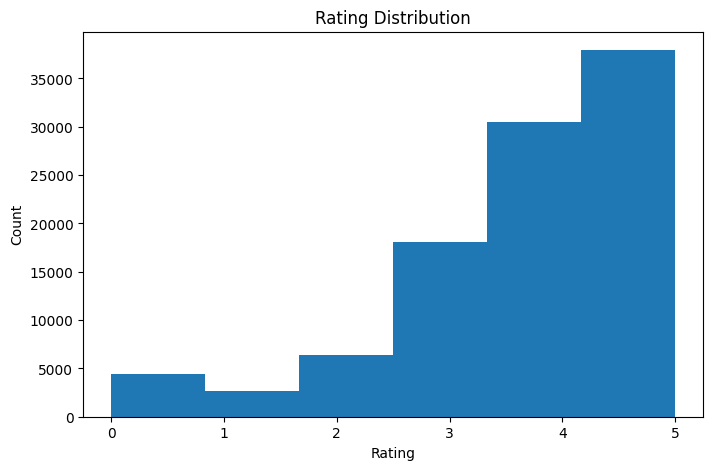

In [69]:
display(users_df.isnull().sum()) 
print("Number of Duplicated Rows = {}".format(users_df.duplicated().sum()))
users_df = users_df.sample(n=100000)
users_df.info()
print(users_df.describe())
plt.subplots(figsize=(8,5))
plt.hist(users_df['rating'],bins=6)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Rating Distribution')
plt.show()

Note that above, we have also removed all rows where the ```is_read``` collumn is set to FALSE, as we are only concered about reviews by users who have read the book they have given a rating to.

### Items DataFrame ###

book_id             0
title               0
language_code       0
authors             0
description         0
publication_year    0
num_pages           0
average_rating      0
dtype: int64

Number of Duplicated Rows = 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36514 entries, 0 to 36513
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   book_id           36514 non-null  int64  
 1   title             36514 non-null  object 
 2   language_code     36514 non-null  object 
 3   authors           36514 non-null  object 
 4   description       36514 non-null  object 
 5   publication_year  36514 non-null  object 
 6   num_pages         36514 non-null  object 
 7   average_rating    36514 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 2.2+ MB
            book_id  average_rating
count  3.651400e+04    36514.000000
mean   1.063452e+07        4.063838
std    1.035345e+07        0.399965
min    2.340000e+02        0.000000
25%    1.185514e+06        3.840000
50%    7.223308e+06        4.100000
75%    1.821872e+07        4.310000
max    3.648548e+07        5.000000


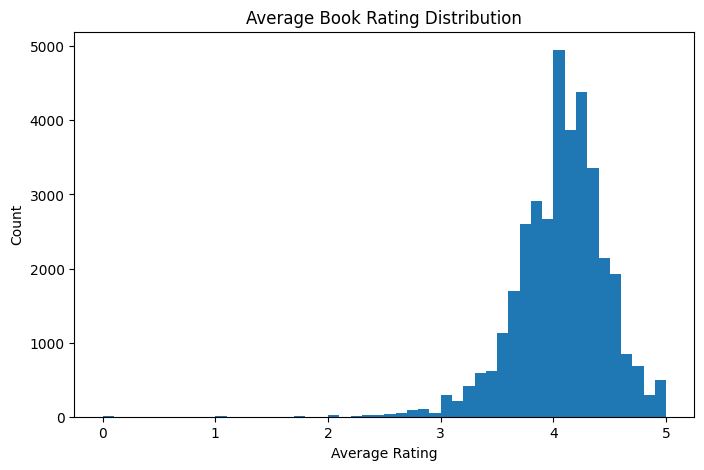

In [68]:
display(items_df.isnull().sum()) 
print("Number of Duplicated Rows = {}".format(items_df['book_id'].duplicated().sum()))
items_df.info()
print(items_df.describe())
plt.subplots(figsize=(8,5))
plt.hist(items_df['average_rating'],bins=50)
plt.xlabel('Average Rating')
plt.ylabel('Count')
plt.title('Average Book Rating Distribution')
plt.show()

## Creating Our First Model ##

Now it's time to get stuck into building our initial model with Shaped! For simplicity, we are going to start off with using just the ratings given by users to build a filtering system. This means that we will only have to use the ```events_df``` at the moment, as it has every nessacary datatype required to build a basic filtering model. Shaped will ingest our data, and use the ratings in order to determine other poems on GoodReads that a given user may like, assuming that the higher the rating of a poem, the more likeley it is that a user will enjoy the poem. In order to start doing this, we first have to create a ```.yaml``` file outlying the schema for our model:

### .Yaml Dataset Schema Creation ###

In [12]:

dir_path = "notebook_assets"

events_dataset_schema = {
    "dataset_name": "goodreads_events",
    "schema_type": "CUSTOM",
    "schema": {
        "user_id": "String",
        "book_id": "String",
        "rating": "Int64",
        "date_added": "String"       
    }
}

with open(f'{dir_path}/events_dataset_schema.yaml', 'w') as file:
    yaml.dump(events_dataset_schema, file)

users_dataset_schema = {
    "dataset_name": "goodreads_users",
    "schema_type": "CUSTOM",
    "schema": {
        "user_id": "String"
    }
}

with open(f'{dir_path}/users_dataset_schema.yaml', 'w') as file:
    yaml.dump(users_dataset_schema, file)

items_dataset_schema = {
    "dataset_name": "goodreads_items",
    "schema_type": "CUSTOM",
    "schema": {
        "book_id": "String",
        "publication_year": "String",
        "num_pages": "Int64"
    }
}

with open(f'{dir_path}/items_dataset_schema.yaml', 'w') as file:
    yaml.dump(items_dataset_schema, file)

Now lets create the infaastructure for these datasets using the outlined yaml files above and the Shaped ```create-dataset``` command:

In [15]:
! shaped create-dataset --file $data_dir/events_dataset_schema.yaml
! shaped create-dataset --file $data_dir/users_dataset_schema.yaml
! shaped create-dataset --file $data_dir/items_dataset_schema.yaml

{
  "dataset_name": "goodreads_events",
  "schema": {
    "book_id": "String",
    "date_added": "String",
    "rating": "Int64",
    "user_id": "String"
  },
  "schema_type": "CUSTOM"
}
message: Dataset with name 'goodreads_events' was successfully scheduled for creation

{
  "dataset_name": "goodreads_users",
  "schema": {
    "user_id": "String"
  },
  "schema_type": "CUSTOM"
}
message: Dataset with name 'goodreads_users' was successfully scheduled for creation

{
  "dataset_name": "goodreads_items",
  "schema": {
    "book_id": "String",
    "num_pages": "Int64",
    "publication_year": "String"
  },
  "schema_type": "CUSTOM"
}
message: Dataset with name 'goodreads_items' was successfully scheduled for creation



It might take a little while for Shaped to successfully schedule and create the infrastructure for these datasets, but you can easily monitor the progress of this using the CLI command below:

In [16]:
! shaped list-datasets

datasets:
- dataset_name: goodreads_events
  dataset_uri: https://api.prod.shaped.ai/v1/datasets/goodreads_events
  created_at: 2023-08-30T14:47:25 UTC
  schema_type: CUSTOM
  status: ACTIVE
- dataset_name: goodreads_users
  dataset_uri: https://api.prod.shaped.ai/v1/datasets/goodreads_users
  created_at: 2023-08-30T14:47:27 UTC
  schema_type: CUSTOM
  status: ACTIVE
- dataset_name: goodreads_items
  dataset_uri: https://api.prod.shaped.ai/v1/datasets/goodreads_items
  created_at: 2023-08-30T14:47:29 UTC
  schema_type: CUSTOM
  status: ACTIVE



### Uploading Data to Shaped ###

Now let's upload our DataFrames to shaped to place in the infastructure we have just created. You can use multiple different file formats to achieve this, one of them being a simple .csv format. Let's save our DataFrames to individual csv's in our working directory and insert them into Shaped:

In [17]:
events_df.to_csv('notebook_assets/events_df.csv')
users_df.to_csv('notebook_assets/users_df.csv')
items_df.to_csv('notebook_assets/items_df.csv')

In [18]:
! shaped dataset-insert --dataset-name goodreads_events --file notebook_assets/events_df.csv --type 'csv'
! shaped dataset-insert --dataset-name goodreads_users --file notebook_assets/users_df.csv --type 'csv'
! shaped dataset-insert --dataset-name goodreads_items --file notebook_assets/items_df.csv --type 'csv'

100000 Records [04:43, 352.26 Records/s]
100000 Records [05:51, 284.48 Records/s]
36514 Records [02:13, 273.58 Records/s]


### Model Schema Creation ###

Now let's detail the schema Shaped will use to create our model for us. We will create another ```.yaml``` file for this, with the following key elements:

- ```model``` : Defines the Name of the model created
- ```connectors``` : Specifies the data to be used to feed into Shaped
- ```fetch``` : Specifies which data collumns will be used as information for events,users and items

In [19]:
poetry_rating_schema = {
    
    "model": {
        "name": "goodreads_rating_model"
    },
     "connectors": [
        {
                "type": "Dataset",
                "id": "goodreads_events",
                "name": "goodreads_events"
        },
        {
                "type": "Dataset",
                "id": "goodreads_users",
                "name": "goodreads_users"
        },
        {
                "type": "Dataset",
                "id": "goodreads_items",
                "name": "goodreads_items"
        },
    ],
    
    "fetch": {
        "events": "SELECT user_id, book_id AS item_id, date_added AS created_at, rating AS label FROM goodreads_events",
        "users": "SELECT user_id FROM goodreads_events",
        "items": "SELECT book_id AS item_id FROM goodreads_events" 
    }
}

with open(f'{dir_path}/poetry_rating_schema.yaml', 'w') as file:
    yaml.dump(poetry_rating_schema, file)

In [20]:
! shaped create-model --file notebook_assets/poetry_rating_schema.yaml

{
  "connectors": [
    {
      "id": "goodreads_events",
      "name": "goodreads_events",
      "type": "Dataset"
    },
    {
      "id": "goodreads_users",
      "name": "goodreads_users",
      "type": "Dataset"
    },
    {
      "id": "goodreads_items",
      "name": "goodreads_items",
      "type": "Dataset"
    }
  ],
  "fetch": {
    "events": "SELECT user_id, book_id AS item_id, date_added AS created_at, rating AS label FROM goodreads_events",
    "items": "SELECT book_id AS item_id FROM goodreads_events",
    "users": "SELECT user_id FROM goodreads_events"
  },
  "model": {
    "name": "goodreads_rating_model"
  }
}
model_url: https://api.prod.shaped.ai/v1/models/goodreads_rating_model



It may take a moment for Shaped to start building the model, but as above, you can call another CLI command to monitor the progress of your model:

In [21]:
! shaped list-models

models:
- model_name: goodreads_rating_model
  model_uri: https://api.prod.shaped.ai/v1/models/goodreads_rating_model
  created_at: 2023-08-30T15:00:58 UTC
  status: SCHEDULING



When creating a model, Shaped goes through the following stages:

- ```SCHEDULING```
- ```FETCHING```
- ```TRAINING```
- ```DEPLOYING```
- ```ACTIVE```

Shaped may take a couple of hours, depending on the size of your data, to progress to the ```ACTIVE``` stage. Once this has occured, we can then use our model to make ranking requests.

## Ranking with Shaped ##

Now we are ready to rank. Using Shaped's Rank Endpoint, we can find out the model's output for the highest rated books/poems for a given user. This output takes the form of a parralell array, with each ```book_id``` corresponding to it's relevance score:

In [28]:
! shaped rank --model-name goodreads_rating_model --user-id '8842281e1d1347389f2ab93d60773d4d' --limit 5

ids:
- '30119'
- '1381'
- '1420'
- '1371'
- '30118'
scores:
- 0.36723583
- 0.32046523
- 0.291512
- 0.128846
- 0.12298936



Although we now have our model working and giving us reccomendations for a given user, this model is not very useful. Because it was trained solely on the event rating data, this model essentially will give us reccommendations for the highest rated books/poems within the dataset. To improve this, we can enrich our shaped model with additional features contained in the goodreads poetry dataset.

## Enriching Our Model ##

Let's take another look at the collumns featured in our three dataframes:

In [22]:
print("Events DataFrame Columns = {}".format(events_df.columns.values))
print("Users DataFrame Columns = {}".format(users_df.columns.values))
print("Items DataFrame Columns = {}".format(items_df.columns.values))

Events DataFrame Columns = ['user_id' 'book_id' 'review_id' 'is_read' 'rating' 'date_added']
Users DataFrame Columns = ['user_id' 'book_id' 'review_id' 'rating' 'review_text' 'date_added'
 'n_votes']
Items DataFrame Columns = ['book_id' 'title' 'language_code' 'authors' 'description'
 'publication_year' 'num_pages' 'average_rating']


Although we do not have any additional user data that may be beneficial for user personalisation, we do have some item data that could be useful. For the sake of simplicity, we wont worry about any item features that are free form text fields, such as titles,authors and descriptions. The relevant item features we should look at are:

 - ```num_pages```
 - ```publication_year```
 - ```average_rating```


We will now build a secondary model to include these item features by remaking our dataset and model schema:

In [23]:
! shaped list-datasets

datasets:
- dataset_name: goodreads_events
  dataset_uri: https://api.prod.shaped.ai/v1/datasets/goodreads_events
  created_at: 2023-08-30T14:47:25 UTC
  schema_type: CUSTOM
  status: ACTIVE
- dataset_name: goodreads_users
  dataset_uri: https://api.prod.shaped.ai/v1/datasets/goodreads_users
  created_at: 2023-08-30T14:47:27 UTC
  schema_type: CUSTOM
  status: ACTIVE
- dataset_name: goodreads_items
  dataset_uri: https://api.prod.shaped.ai/v1/datasets/goodreads_items
  created_at: 2023-08-30T14:47:29 UTC
  schema_type: CUSTOM
  status: ACTIVE



In [24]:
goodreads_rating_model_schema_rich = {
    "model": {
        "name": "goodreads_rating_model_rich"
    },
      "connectors": [
        {
                "type": "Dataset",
                "id": "goodreads_events",
                "name": "goodreads_events"
        },
        {
                "type": "Dataset",
                "id": "goodreads_users",
                "name": "goodreads_users"
        },
        {
                "type": "Dataset",
                "id": "goodreads_items",
                "name": "goodreads_items"
        },
    ],
    "fetch": {
            "events": "SELECT user_id, book_id AS item_id, date_added AS created_at, rating AS label FROM goodreads_events",
            "users": "SELECT user_id FROM goodreads_users",
            "items": "SELECT book_id AS item_id, num_pages, publication_year FROM goodreads_items" 
    }
}

with open(f'{dir_path}/goodreads_rating_model_schema_rich.yaml', 'w') as file:
    yaml.dump(goodreads_rating_model_schema_rich, file)

In [25]:
! shaped create-model --file notebook_assets/goodreads_rating_model_schema_rich.yaml

{
  "connectors": [
    {
      "id": "goodreads_events",
      "name": "goodreads_events",
      "type": "Dataset"
    },
    {
      "id": "goodreads_users",
      "name": "goodreads_users",
      "type": "Dataset"
    },
    {
      "id": "goodreads_items",
      "name": "goodreads_items",
      "type": "Dataset"
    }
  ],
  "fetch": {
    "events": "SELECT user_id, book_id AS item_id, date_added AS created_at, rating AS label FROM goodreads_events",
    "items": "SELECT book_id AS item_id, num_pages, publication_year FROM goodreads_items",
    "users": "SELECT user_id FROM goodreads_users"
  },
  "model": {
    "name": "goodreads_rating_model_rich"
  }
}
model_url: https://api.prod.shaped.ai/v1/models/goodreads_rating_model_rich



In [37]:
! shaped rank --model-name goodreads_rating_model_rich --user-id 9 --limit 5	

ids:
- '1381'
- '1420'
- '2696'
- '15645'
- '23513349'
scores:
- 0.32046523
- 0.291512
- 0.09279881
- 0.05040007
- 0.03860431



Although we now have a model that is taking in additional item data, this model is still quite limited in terms of user personalization. Because our dataset does not contain any other potentially useful personal user information such as age,sex,occupation,location,etc, the model is not capable of personalizing results for different users, as the only thing that it has at it's disposal to differentiate between users is an arbitrary id string. This essentially results in the model treating relevance ratings as the same for all users. If we had access to more robust user profile data, this model could potentially become better at personalizing poetry books that may have some underlying connection/relevance to specific user information.

## A/B Testing ##

If a potential customer were to consider using one of these ranking models in production, an A/B test would be neccasary. Let's assume that the aim of a model like this would be to increase user satisfaction with the goodreads service, whilst also increasing user engagement. A customer would need to set up an A/B test as follows:

- Each user that visits the website would randomly be directed to A: The Website without model ranking integration or B: The Website with model ranking intergration. Each individual user would have a 50% chance of being directed to either scenario
- The user would then be asked to quickly evaluate their experience with the website, possibly on a simply 1-5 star rating system
- The customer would also track user engagement for websites A and B, possibly with metrics such as retention rate, average session length, session frequency
- The effectiveness of the ranking model integration would then be evaluated by seeing whether the website sees better user engagement either with or out the model

## Model Extensions ##

If more time was allowed to improve the effectiveness and personalisation factor of the model, a few options could be explored. Firstly, the retrieval of additional user data as mentioned above could be used to improve the model's ability to determine different types of users, and change/update real time book reccommendations accordingly. This could be done by simply retrieving personal user profile data for the accounts people use for GoodReads.com, and incorperating it into the 'users' section of the model fetch schema. 

Additionally, work on the potential usefullness of using Language Model encodings for free form text data could be undergone. Item data such as Titles, Authors, Descriptions and individual user text reviews could be used in conjuction with a LLM component to develop semantic vector reperesentations that could further identify books and if they fall into increasingly complex relevant categorisations such as:

 - Genre
 - Poem Structure (Free Verse,Sonnet,Haiku,Limerick,etc.)
 - Verbosity (i.e how complex/simplistic language used is)

These two potential avenues in conjuction with each other could definitely improve the ablity of the model to personalize reccommendations based on the specific user and what they are searching for in new book discoveries. 